In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, Bounds
from sympy import symbols, solve, lambdify

In [2]:
mpl.rcParams['font.size'] = 22
mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Start the testing data at 150um from the QC, since this is when the last division takes place
TIMES =  np.array([6.7, 11, 15, 18, 20, 21, 22])
PRECURSORS = np.array([1.5, 1.65, 2, 2.35, 2.85, 2.65, 2.65])
SIGNALS = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
SIZES = np.array([7, 9, 13, 20, 30, 42, 55])

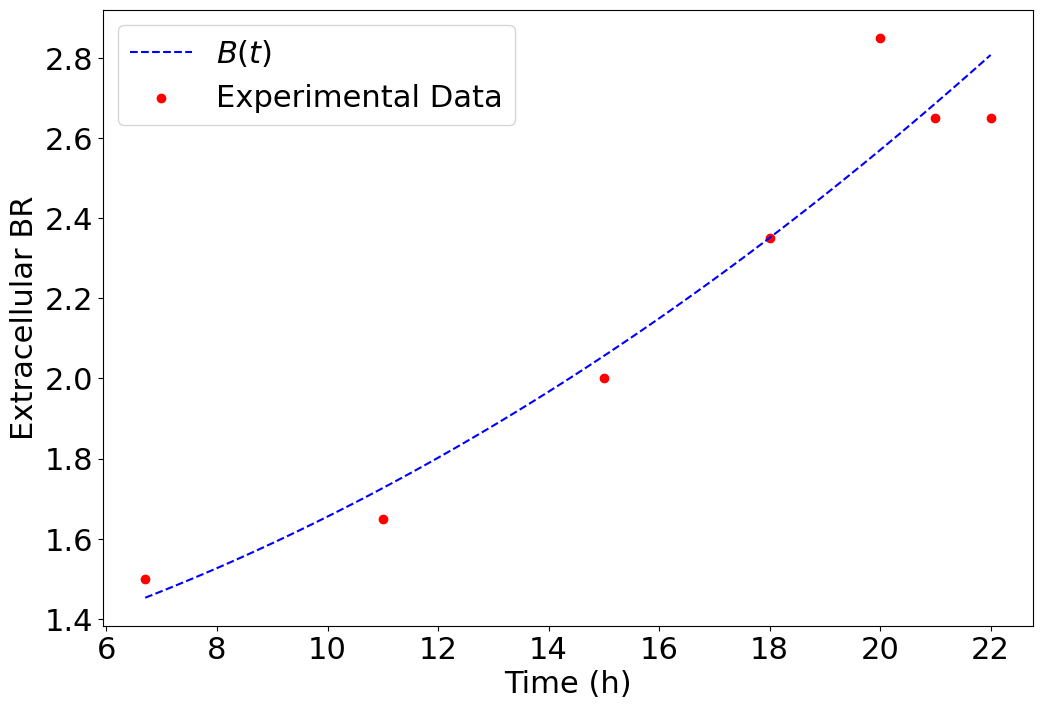

In [4]:
# Find the polynomial of best fit and graph it
BR = np.poly1d(np.polyfit(TIMES, PRECURSORS, 2))
xs = np.linspace(min(TIMES), max(TIMES), 100)
plt.plot(xs, BR(xs), color = "blue", ls = "--", label = r"$B(t)$")

# Add a scatterplot of the original points
plt.scatter(TIMES, PRECURSORS, color = "red", label = "Experimental Data")
plt.xlabel("Time (h)")
plt.ylabel("Extracellular BR")
plt.legend()
plt.savefig("img/prototype-2-br.png")

## Equations

$$
\begin{cases}
\dfrac{ dC }{ dt } = c_{\text{max}} - \left(1 + qR_{B} \right)C \\[5pt]
\dfrac{ dR_{0} }{ dt } = u\left(1 + vC\right) - k_{\text{on}}R_{0}B + k_{\text{off}}R_{B} - R_{0}\\[5pt]
\dfrac{ dR_{B} }{ dt } = k_{\text{on}}R_{0}B - k_{\text{off}}R_{B} - R_{B} \\[5pt]
\dfrac{ dM }{ dt } = \alpha_{ M } C - M  \\[5pt]
\dfrac{ dL }{ dt } = g_{B}R_{B} \left( 1 + \dfrac{ g_M M  }{ L }  \right)^{ -1 }
\end{cases}
$$

In [5]:
START = 6.7
STOP = 22
STEP = 0.05
LENGTH = 7
SERIES = np.arange(START, STOP + STEP, STEP)
INITIAL_PARAMS = np.ones(9)

In [6]:
def setup():

    # Define parameters and variables
    params = symbols('c_max, q, u, v, k_on, k_off, a_tau, g_B, g_tau')
    c_max, q, u, v, k_on, k_off, a_tau, g_B, g_tau = params
    
    # Define the initial cell length and symbols
    C, R0, RB, T, B = symbols('C R0 RB T B')
            
    # Solve the system at steady state
    system = [
        c_max - (1 + q*RB)*C,
        u*(1 + v*C) - k_on*R0*B + k_off*RB - R0,
        k_on*R0*B - (1 + k_off)*RB,
        a_tau*C - T
    ]

    # Choose the second root to ensure positive solutions
    steady_states = solve(system, [C, R0, RB, T], dict = True)[-1]
    return [lambdify([params, B], steady_states[hormone]) for hormone in [C, R0, RB, T]]

HORMONES = setup()

In [7]:
def get_growth(params): 
    c_max, q, u, v, k_on, k_off, a_tau, g_B, g_tau = params
    return lambda RB, T, L : (g_B * RB) / (1 + (g_tau * T / L))

# Compute the NRMSE of the model
def check_error(sizes, signals):
    indices = [int((t - START) / STEP) for t in TIMES]
    sizes = [sizes[i] for i in indices]
    signals = [signals[i] for i in indices]
    return (
        sum([(s - S) ** 2 for s, S in zip(sizes, SIZES)]) / sum([S ** 2 for S in SIZES]) +
        sum([(s - S) ** 2 for s, S in zip(signals, SIGNALS)]) / sum([S ** 2 for S in SIGNALS])
    )

def simulate_cell(params):
    sizes, L, growth = [], LENGTH, get_growth(params)
    C, R0, RB, T = [h(params, np.square(BR(SERIES)))for h in HORMONES]
    for rb, t in zip(RB, T):
        L += growth(rb, t, L) * STEP
        sizes.append(L)

    c_max, q, u, v, k_on, k_off, a_tau, g_B, g_tau = params
    signals = np.array(RB) * q
    
    return (C, R0, RB, T, sizes, signals), check_error(sizes, signals)

def cost(params):
    return simulate_cell(params)[-1]

In [12]:
%%time 
simulate_cell(np.ones(9))

CPU times: user 1.1 ms, sys: 49 µs, total: 1.15 ms
Wall time: 1.13 ms


((array([0.5558488 , 0.55546431, 0.55507962, 0.55469474, 0.55430969,
         0.55392446, 0.55353909, 0.55315357, 0.55276792, 0.55238215,
         0.55199627, 0.5516103 , 0.55122424, 0.5508381 , 0.5504519 ,
         0.55006564, 0.54967935, 0.54929302, 0.54890667, 0.54852032,
         0.54813396, 0.54774762, 0.5473613 , 0.54697501, 0.54658876,
         0.54620257, 0.54581644, 0.54543039, 0.54504442, 0.54465855,
         0.54427278, 0.54388713, 0.5435016 , 0.54311621, 0.54273096,
         0.54234587, 0.54196094, 0.54157619, 0.54119162, 0.54080724,
         0.54042307, 0.54003911, 0.53965536, 0.53927185, 0.53888858,
         0.53850556, 0.5381228 , 0.5377403 , 0.53735808, 0.53697614,
         0.5365945 , 0.53621316, 0.53583213, 0.53545142, 0.53507104,
         0.534691  , 0.5343113 , 0.53393195, 0.53355296, 0.53317435,
         0.53279611, 0.53241826, 0.5320408 , 0.53166374, 0.53128709,
         0.53091086, 0.53053505, 0.53015968, 0.52978474, 0.52941025,
         0.52903622, 0.52866265, 0

In [8]:
%%time
res = minimize(
    cost, 
    INITIAL_PARAMS, 
    method='trust-constr', 
    bounds=Bounds(0.01, 100), 
    options={"maxiter": 10000}
)

CPU times: user 3.76 s, sys: 4.61 ms, total: 3.76 s
Wall time: 3.78 s


SUCCESS: True `gtol` termination condition is satisfied.
ITERATIONS: 896
PARAMS: [19.91, 0.972, 99.938, 0.037, 0.271, 51.442, 11.256, 99.962, 32.633]
ERROR: 0.0027926967530806845


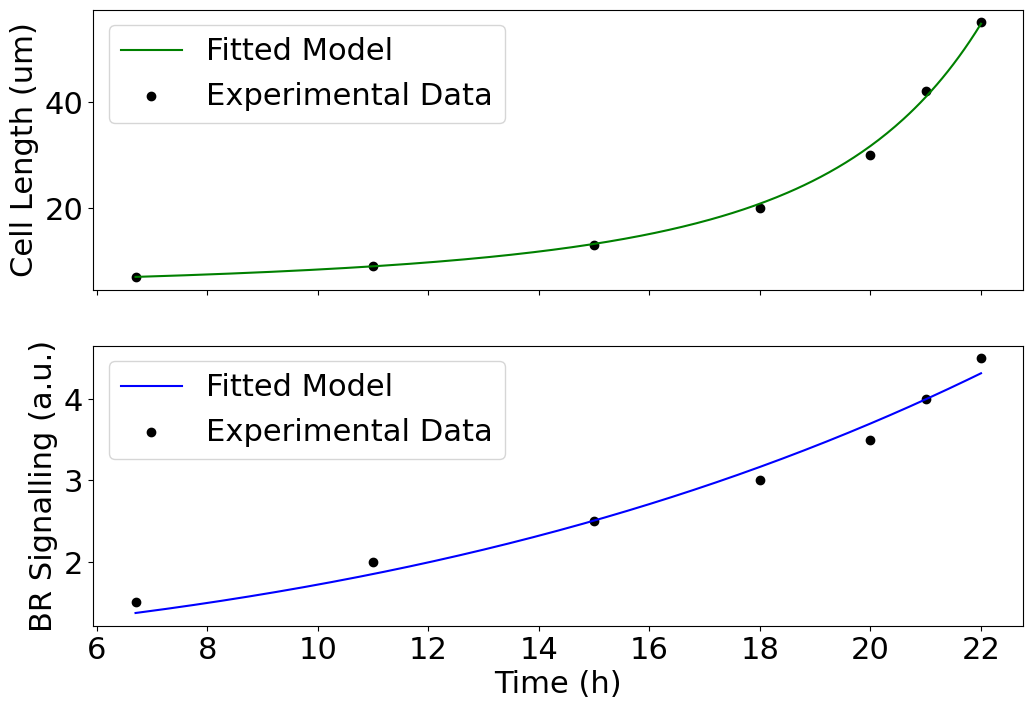

In [9]:
# Test the current parameters against observed data
data, error = simulate_cell(res.x)
C, R0, RB, T, sizes, signals = data

# Plot the results
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, sharex = True)

ax1.plot(SERIES, sizes, color = "green", label = "Fitted Model")
ax1.scatter(TIMES, SIZES, color = "black", label = "Experimental Data")
ax1.set_ylabel("Cell Length (um)")
ax1.legend()

ax2.plot(SERIES, signals, color = "blue", label = "Fitted Model")
ax2.scatter(TIMES, SIGNALS, color = "black", label = "Experimental Data")
ax2.set_ylabel("BR Signalling (a.u.)")
ax2.set_xlabel("Time (h)")
ax2.legend()

mpl.rcParams['figure.figsize'] = (12, 12)
fig.savefig("img/prototype-3b-square-model.png")

# Print off information about the optimization
print("SUCCESS:", res.success, res.message)
print("ITERATIONS:", res.nit)
print("PARAMS:", [round(p, 3) for p in list(res.x)])
print("ERROR:", error)

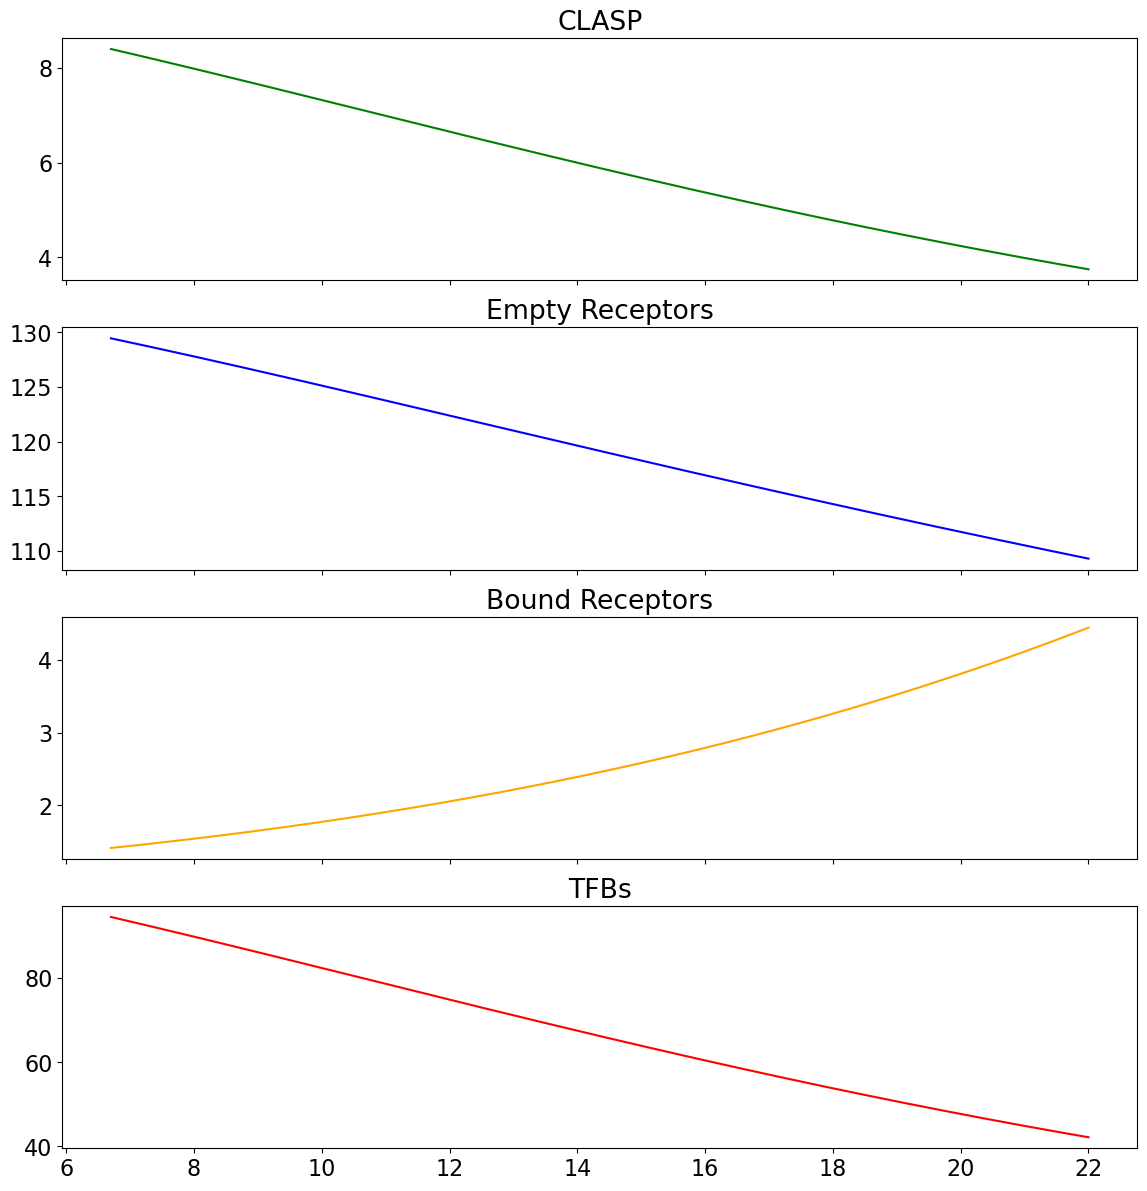

In [10]:
# Plot the other hormones
mpl.rcParams['font.size'] = 16
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 1, nrows = 4, sharex=True)
fig.tight_layout()

ax1.plot(SERIES, C, color = "green")
ax1.set_title("CLASP")
# ax1.set_ylim(0, 10 ** 3)

ax2.plot(SERIES, R0, color = "blue")
ax2.set_title("Empty Receptors")
# ax2.set_ylim(0, 3 * 10 ** 6)

ax3.plot(SERIES, RB, color = "orange")
ax3.set_title("Bound Receptors")
# ax3.set_ylim(0, 4 * 10 ** 3)

ax4.plot(SERIES, T, color = "red")
ax4.set_title("TFBs")
# ax4.set_ylim(0, 6 * 10 ** 4)

plt.show()

In [11]:
# Attempt to run minimization on every fitting algorithm with a variety of bounds
methods = ['Nelder-Mead', 'L-BFGS-B', 'SLSQP', 'Powell', 'trust-constr', 'COBYLA']
bounds = [Bounds(10 ** -i, 10 ** i) for i in range(2, 6)]
tests = [(m, b) for m in methods for b in bounds]

for t in tests:
    method, bound = t
    res = minimize(cost, INITIAL_PARAMS, method = method, bounds = bound, options={"maxiter": 1000})
    print(method, res.fun, res.success)

Nelder-Mead 0.012669011983732298 False
Nelder-Mead 0.01818189677470001 False
Nelder-Mead 0.03471416973758134 False
Nelder-Mead 0.015961489587554348 False
L-BFGS-B 0.013661787032406622 True
L-BFGS-B 0.005713504239199051 True
L-BFGS-B 0.03556776057987558 True
L-BFGS-B 0.0026037226760185104 True
SLSQP 0.002872297443629038 True
SLSQP 0.015459541911857484 True


/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


SLSQP 0.0037111508699990744 True
SLSQP 0.003057225680696209 True
Powell 0.13245911864051485 True
Powell 0.13245968759899202 True
Powell 0.13245926315223355 True
Powell 0.13245761758585442 True
trust-constr 0.0027926967530806845 True
trust-constr 0.002696556487432861 False
trust-constr 0.003058075671941208 False
trust-constr 0.0026894341008398283 False
COBYLA 0.07469414482029918 False
COBYLA 0.07469414482029918 False
COBYLA 0.07469414482029918 False
COBYLA 0.07469414482029918 False
